In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp  /content/drive/MyDrive/kvasir_dataset.zip .

In [3]:
!unzip -qq kvasir_dataset.zip

In [ ]:
import os
import shutil

images = []
i=0
class_name = "ulcerative-colitis"

for f in os.listdir('kvasir/'+class_name+'/'+class_name):
  if i<200:
    images.append('kvasir/'+class_name+'/'+class_name+'/'+f)
    i+=1

In [ ]:
for image in images:
    new_path = 'test/'+class_name+'/'
    shutil.move(image, new_path)

In [4]:
!git clone https://github.com/yingkaisha/keras-vision-transformer.git

Cloning into 'keras-vision-transformer'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 95 (delta 45), reused 35 (delta 12), pack-reused 0
Unpacking objects: 100% (95/95), 155.59 KiB | 4.20 MiB/s, done.


In [5]:
%cd keras-vision-transformer

/content/keras-vision-transformer


In [7]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D
import sys
sys.path.append('../')

from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers

In [6]:
imagePaths = "../kvasir_dataset/train/"
test_path = "../kvasir_dataset/test/"

In [8]:
batch_size=32
img_height = 128
img_width = 128

In [9]:
import tensorflow as tf

In [10]:
!rm -rf ../kvasir_dataset/train/.ipynb_checkpoints

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 15300 files belonging to 6 classes.
Using 12240 files for training.


In [ ]:
#label_mode='categorical'

In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 15300 files belonging to 6 classes.
Using 3060 files for validation.


In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.


In [14]:
import matplotlib.pyplot as plt

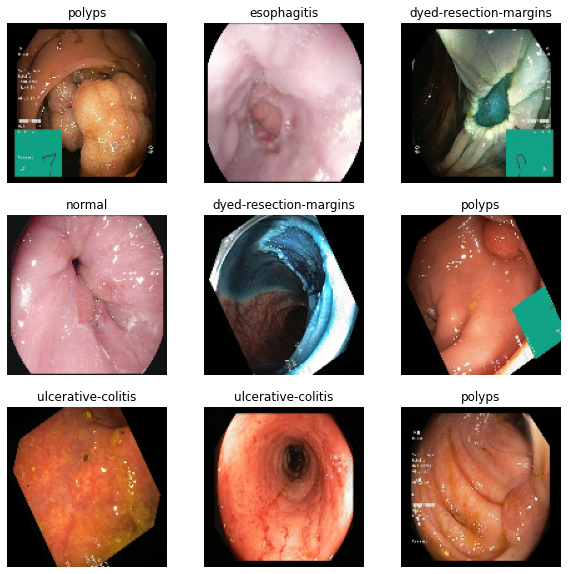

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
input_size = (128, 128, 3) 
patch_size = (2, 2) # Segment 28-by-28 frames into 2-by-2 sized patches, patch contents and positions are embedded
n_labels = 6 

# Dropout parameters
mlp_drop_rate = 0.01 # Droupout after each MLP layer
attn_drop_rate = 0.01 # Dropout after Swin-Attention
proj_drop_rate = 0.01 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
drop_path_rate = 0.01 # Drop-path within skip-connections

# Self-attention parameters 
# (Fixed for all the blocks in this configuration, but can vary per block in larger architectures)
num_heads = 8 # Number of attention heads
embed_dim = 64 # Number of embedded dimensions
num_mlp = 256 # Number of MLP nodes
qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor

# Shift-window parameters
window_size = 2 # Size of attention window (height = width)
shift_size = window_size // 2 # Size of shifting (shift_size < window_size)

num_patch_x = input_size[0]//patch_size[0]
num_patch_y = input_size[1]//patch_size[1]


In [16]:
from tensorflow.keras import layers

In [17]:
from tensorflow.keras.models import Sequential

In [18]:
data_augmentation= Sequential([
                               layers.RandomBrightness(factor=0.2, value_range=(0, 255), seed=123)
])
    

In [19]:
# The input section
IN = Input(input_size)
X = data_augmentation(IN)
X = layers.Rescaling(1./255)(X)


# Extract patches from the input tensor
X = transformer_layers.patch_extract(patch_size)(X)

# Embed patches to tokens
X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)

# -------------------- Swin transformers -------------------- #
# Stage 1: window-attention + Swin-attention + patch-merging

for i in range(2):
    
    if i % 2 == 0:
        shift_size_temp = 0
    else:
        shift_size_temp = shift_size

    X = swin_layers.SwinTransformerBlock(dim=embed_dim, num_patch=(num_patch_x, num_patch_y), num_heads=num_heads, 
                             window_size=window_size, shift_size=shift_size_temp, num_mlp=num_mlp, qkv_bias=qkv_bias, qk_scale=qk_scale,
                             mlp_drop=mlp_drop_rate, attn_drop=attn_drop_rate, proj_drop=proj_drop_rate, drop_path_prob=drop_path_rate, 
                             name='swin_block{}'.format(i))(X)
# Patch-merging
#    Pooling patch sequences. Half the number of patches (skip every two patches) and double the embedded dimensions
X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)

# ----------------------------------------------------------- #

# Convert embedded tokens (2D) to vectors (1D)
X = GlobalAveragePooling1D()(X)
#X = layers.Flatten()(X)
# The output section
OUT = Dense(6, activation='softmax')(X)

In [20]:
model = keras.models.Model(inputs=IN, outputs=OUT)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 patch_extract (patch_extrac  (None, 4096, 12)         0         
 t)                                                              
                                                                 
 patch_embedding (patch_embe  (None, 4096, 64)         262976    
 dding)                                                          
                                                                 
 swin_transformer_block (Swi  (None, 4096, 64)         50072 

In [22]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5)
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy',])

In [23]:
# Training
history = model.fit(train_ds, validation_data=val_ds, batch_size=16, epochs=20)

Epoch 1/20


383/383 [==============================] - 242s 606ms/step - loss: 1.0738 - accuracy: 0.5155 - val_loss: 0.8824 - val_accuracy: 0.5980
Epoch 2/20
383/383 [==============================] - 233s 599ms/step - loss: 0.8409 - accuracy: 0.5991 - val_loss: 0.7467 - val_accuracy: 0.6507
Epoch 3/20
383/383 [==============================] - 232s 597ms/step - loss: 0.7734 - accuracy: 0.6279 - val_loss: 0.6984 - val_accuracy: 0.6758
Epoch 4/20
383/383 [==============================] - 232s 597ms/step - loss: 0.7359 - accuracy: 0.6513 - val_loss: 0.6536 - val_accuracy: 0.6902
Epoch 5/20
383/383 [==============================] - 233s 601ms/step - loss: 0.7113 - accuracy: 0.6632 - val_loss: 0.6421 - val_accuracy: 0.6958
Epoch 6/20
383/383 [==============================] - 232s 598ms/step - loss: 0.6925 - accuracy: 0.6662 - val_loss: 0.6334 - val_accuracy: 0.7078
Epoch 7/20
383/383 [==============================] - 232s 597ms/step - loss: 0.6707 - accuracy: 0.6732 - val_loss: 0.6433 - val_accura

In [24]:
results = model.evaluate(test_ds)

85/85 [==============================] - 46s 496ms/step - loss: 0.5545 - accuracy: 0.7452


In [25]:
import matplotlib.pyplot as plt

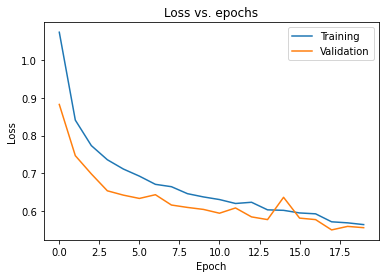

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

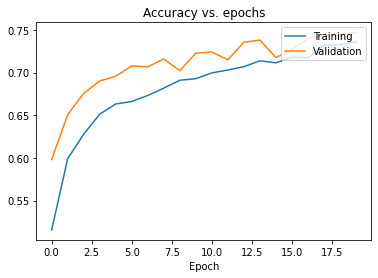

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
import numpy as np

In [30]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 0s 478ms/step


In [31]:
print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

Confusion Matrix
[[234 213   0   0   3   0]
 [ 82 367   0   0   1   0]
 [  0   0 382  68   0   0]
 [  1   0  26 416   5   2]
 [ 14   0   4  51 313  68]
 [  3   0   5  26 116 300]]


In [32]:
classes=['dyed-lifted-polyps','dyed-resection-margins', 'esophagitis','normal','polyps', 'ulcerative-colitis']
     
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.70      0.52      0.60       450
dyed-resection-margins       0.63      0.82      0.71       450
           esophagitis       0.92      0.85      0.88       450
                normal       0.74      0.92      0.82       450
                polyps       0.71      0.70      0.70       450
    ulcerative-colitis       0.81      0.67      0.73       450

              accuracy                           0.75      2700
             macro avg       0.75      0.75      0.74      2700
          weighted avg       0.75      0.75      0.74      2700



In [33]:
model.save("swint_kvasir_checkpoints")